In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import seaborn as sns

train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

In [6]:
def convert_date(df):
    df["Unnamed: 0"] = df["Unnamed: 0"].str.split(" ")
    df["Unnamed: 0"] = df["Unnamed: 0"].apply(lambda x: "-".join(x[1:]))
    df = df.rename(columns = {'Unnamed: 0':'Date'})
    df.Date = pd.to_datetime(df.Date)
    return df    

In [7]:
df = pd.concat([train, test])
df = convert_date(df)

train = convert_date(train)
test = convert_date(test)

df = df.sort_values(['sku','Date'])
df = df.reset_index(drop=True)
df

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,2016-12-10,144,MULTI,114.23,BRAND2,2.18,NaN,NaN,NaN,1,51320.0
1,2016-12-17,144,MULTI,114.23,BRAND2,2.00,45.0,100.000000,51320.0,1,66431.0
2,2016-12-24,144,MULTI,114.23,BRAND2,2.05,17.0,100.000000,66431.0,1,57001.0
3,2016-12-31,144,MULTI,114.23,BRAND2,3.00,2.0,100.000000,57001.0,1,15052.0
4,2017-01-07,144,MULTI,114.23,BRAND2,2.99,2.0,28.534193,15052.0,1,22016.0
...,...,...,...,...,...,...,...,...,...,...,...
6014,2019-05-25,2718,SINGLE,395.41,BRAND1,1.11,0.0,26.050480,33875.0,0,33328.0
6015,2019-06-01,2718,SINGLE,395.41,BRAND1,1.30,1.0,43.099496,33328.0,0,22512.0
6016,2019-06-08,2718,SINGLE,395.41,BRAND1,1.55,0.0,0.000000,22512.0,0,17461.0
6017,2019-06-15,2718,SINGLE,395.41,BRAND1,1.55,0.0,0.000000,17461.0,0,17105.0


In [8]:
# Encoding Categorical Features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.pack = le.fit_transform(df.pack)
le.classes_

array(['MULTI', 'SINGLE'], dtype=object)

In [9]:
df.brand = le.fit_transform(df.brand)
le.classes_

array(['BRAND1', 'BRAND2', 'BRAND3', 'BRAND4', 'BRAND5'], dtype=object)

In [10]:
def inverse_interpolation(df, date='2016-12-10'):
    first_we_idx = df[df.Date==pd.to_datetime(date)].index

    df = df.sort_values(['sku', 'Date'])
    for i in first_we_idx:
        inverse_interpolation = 2*df.loc[i+1, 'sales w-1'] - df.loc[i+2, 'sales w-1']
        df.loc[i,'sales w-1'] = inverse_interpolation
        
        inverse_interpolation = 2*df.loc[i+1, 'POS_exposed w-1'] - df.loc[i+2, 'POS_exposed w-1']
        df.loc[i,'POS_exposed w-1'] = inverse_interpolation
        
        inverse_interpolation = 2*df.loc[i+1, 'volume_on_promo w-1'] - df.loc[i+2, 'volume_on_promo w-1']
        df.loc[i,'volume_on_promo w-1'] = inverse_interpolation
    
    return df

df = inverse_interpolation(df)
df = df.sort_values(['Date', 'sku'])
df

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,2016-12-10,144,0,114.23,1,2.18,73.0,100.000000,36209.0,1,51320.0
158,2016-12-10,546,1,114.23,1,0.52,0.0,18.790147,82676.0,1,76232.0
316,2016-12-10,549,1,114.23,1,0.51,0.0,33.797493,42368.0,1,37595.0
474,2016-12-10,554,1,114.23,1,0.52,0.0,27.189644,132734.0,1,122206.0
632,2016-12-10,686,0,125.65,3,2.16,95.0,100.000000,43338.0,1,54995.0
...,...,...,...,...,...,...,...,...,...,...,...
1263,2019-12-14,1035,1,114.23,1,0.55,6.0,36.060336,38087.0,1,NaN
1421,2019-12-14,1051,0,125.65,3,2.99,0.0,100.000000,24597.0,1,NaN
1579,2019-12-14,1058,1,125.65,3,0.56,0.0,25.368425,27794.0,1,NaN
1737,2019-12-14,1065,1,125.65,3,0.57,7.0,37.921239,79456.0,1,NaN


## AUTOCORRELATION sales w-1

C:\Users\david\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\david\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


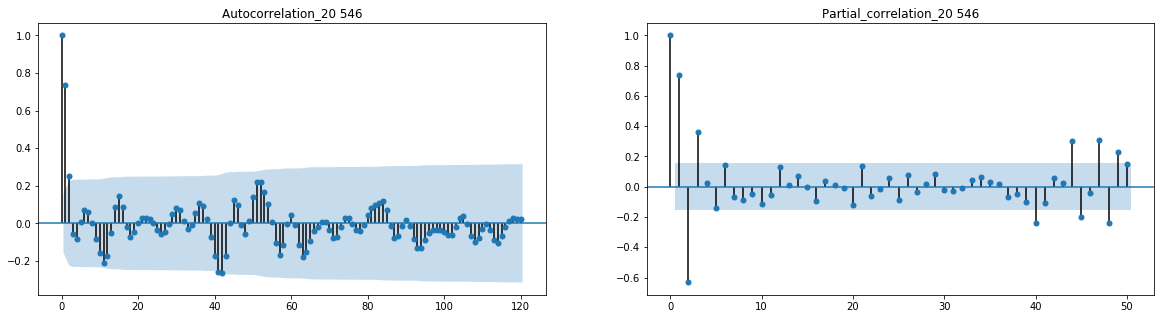

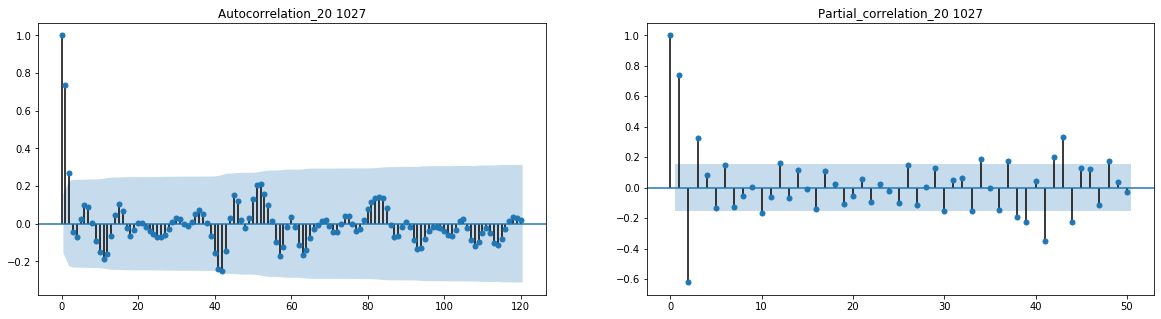

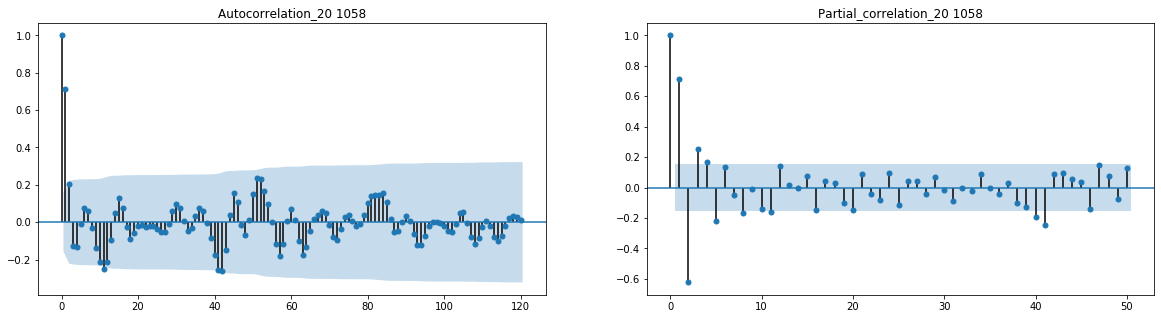

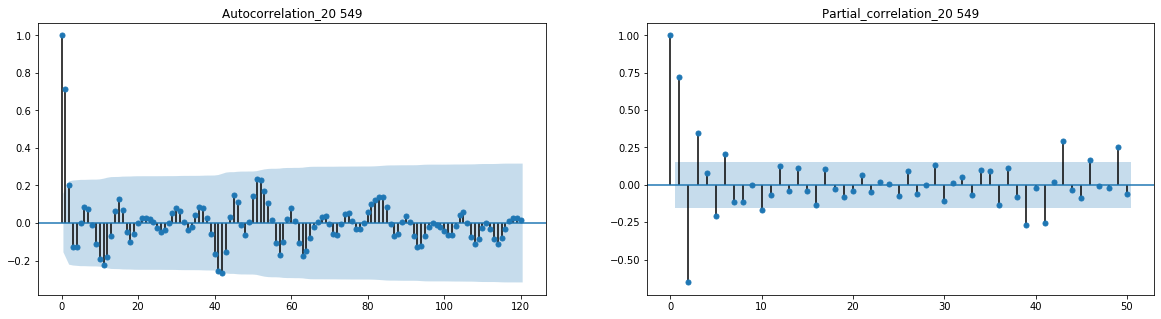

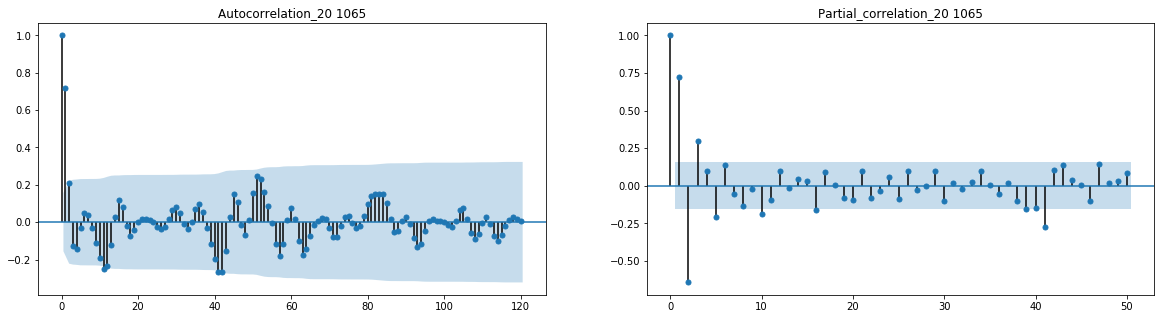

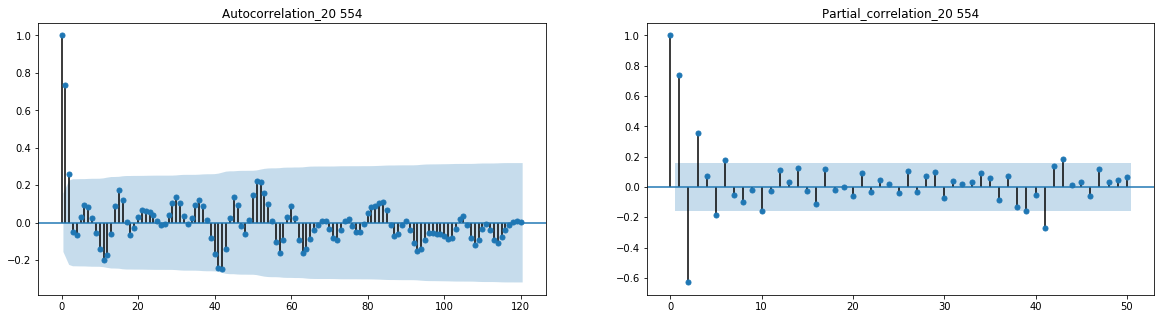

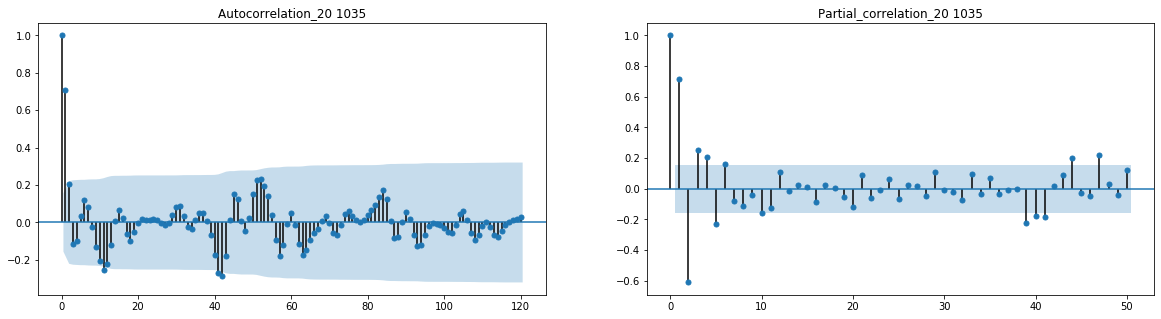

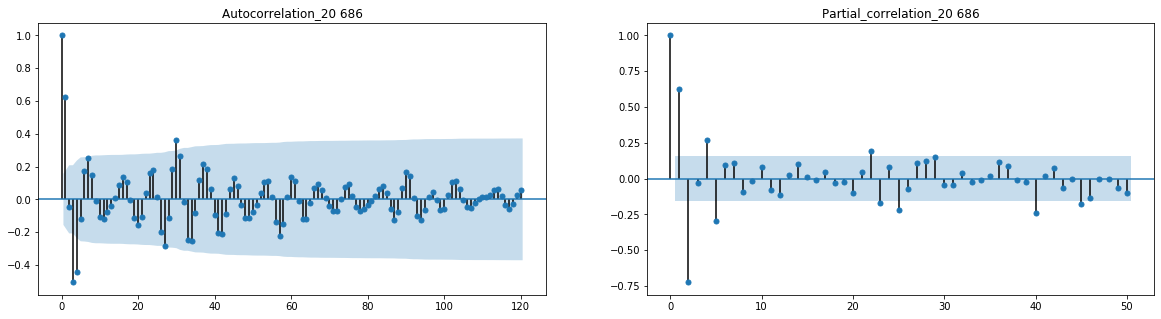

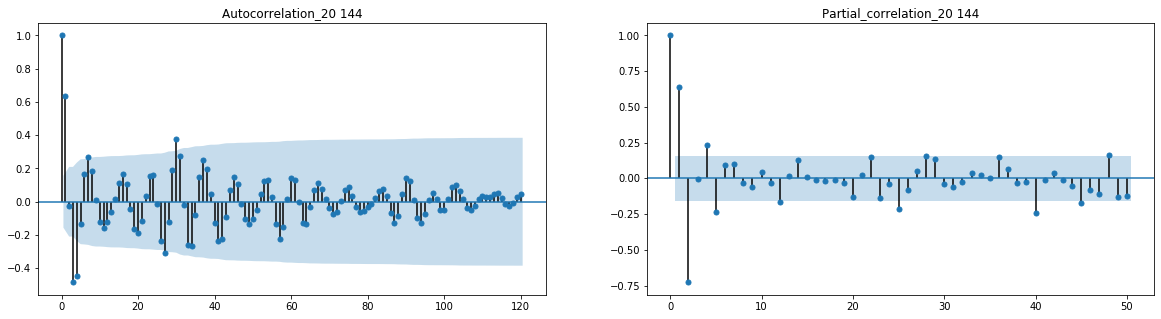

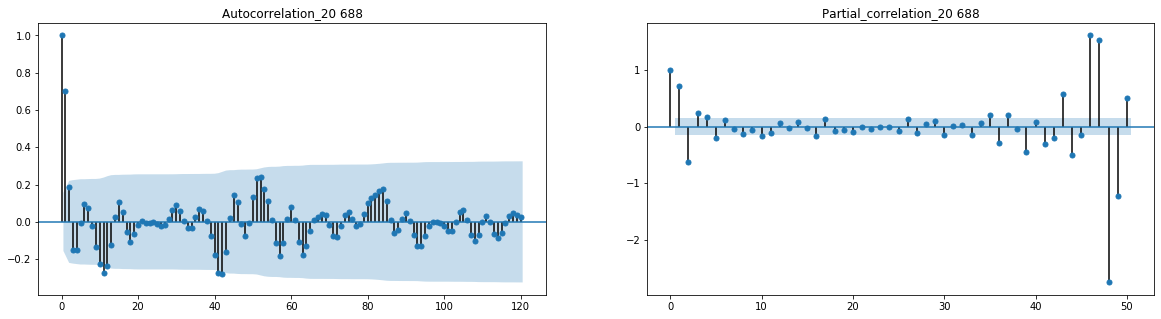

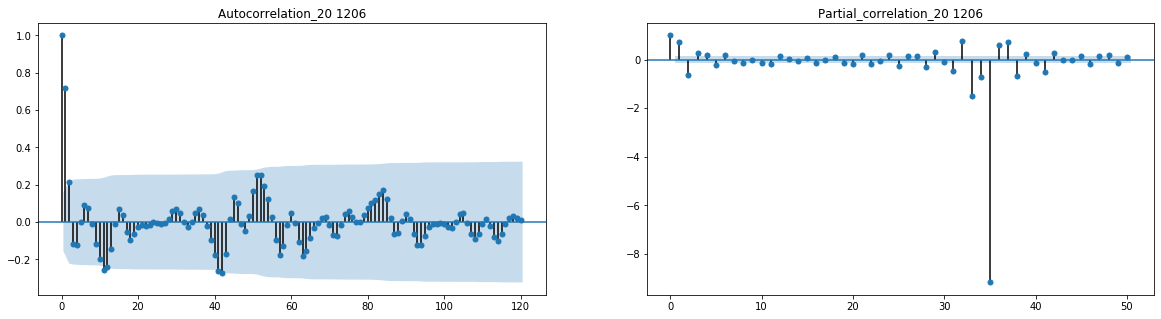

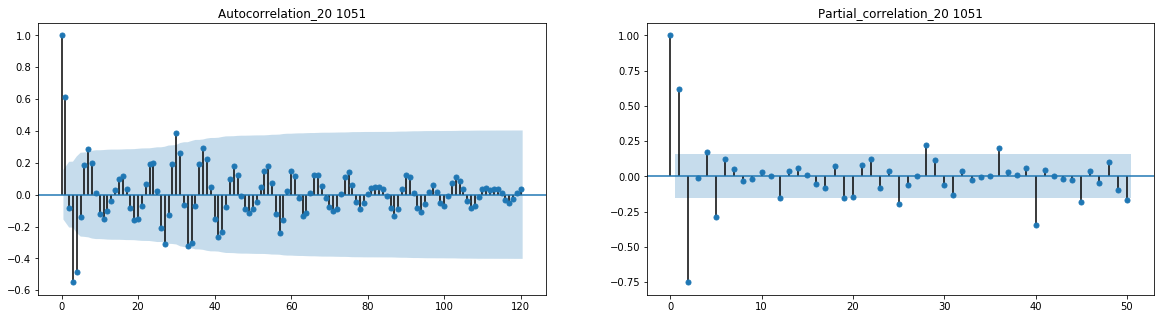

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for s in set(df[df.scope == 1]['sku']):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))    
    
    plot_acf(df[df.sku == s]['sales w-1'], ax=ax[0], lags=120, title="Autocorrelation_20 " + str(s))
    plot_pacf(df[df.sku == s]['sales w-1'], ax=ax[1], lags=50, title="Partial_correlation_20 " + str(s))

## AUTOCORRELATION POS_exposed w-1

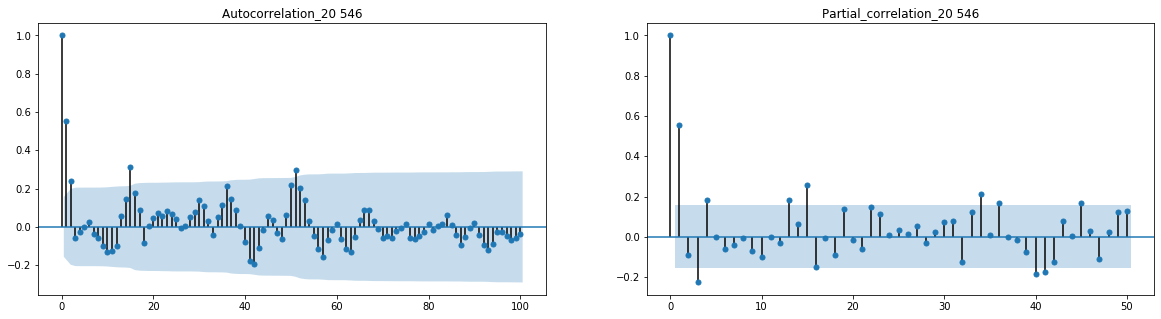

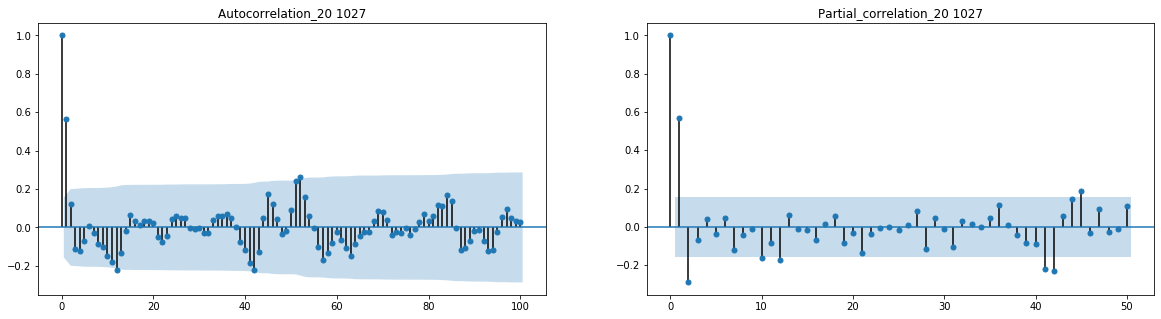

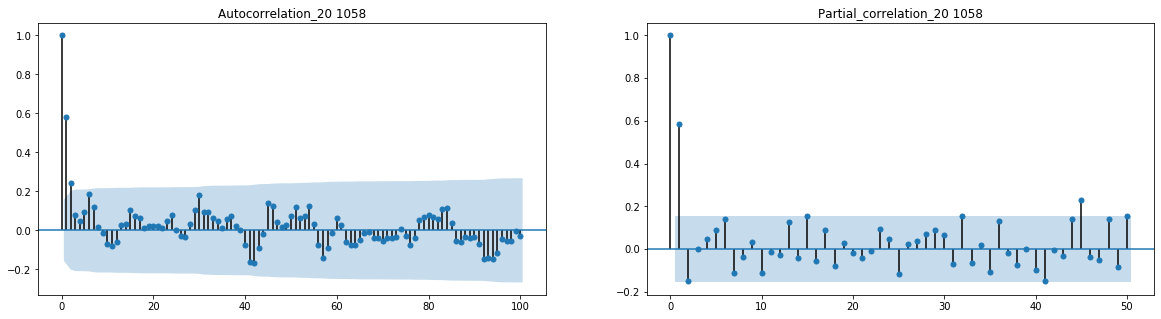

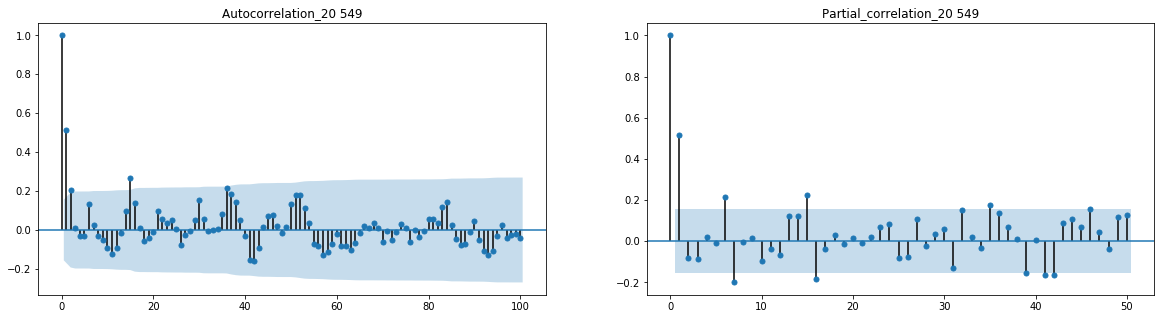

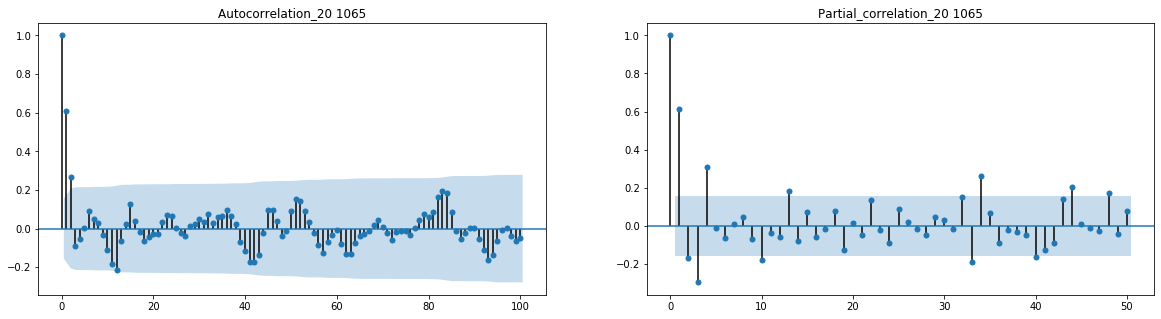

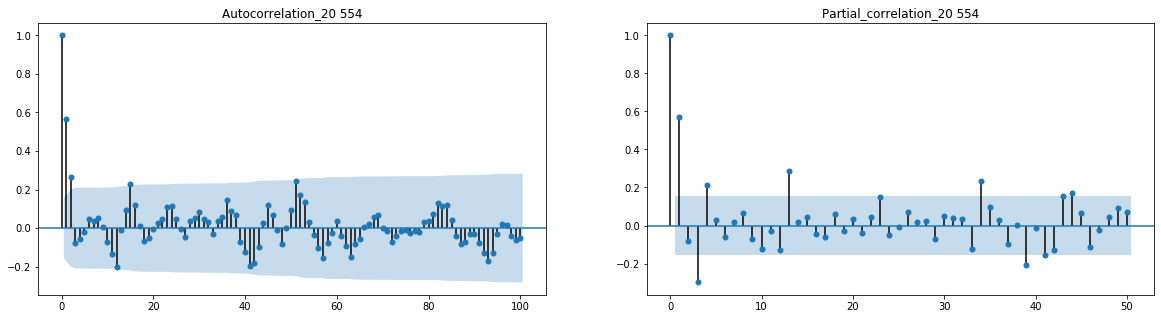

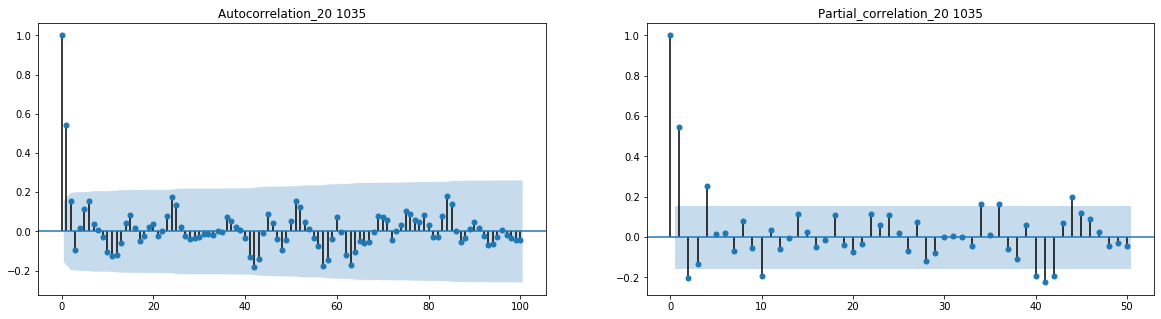

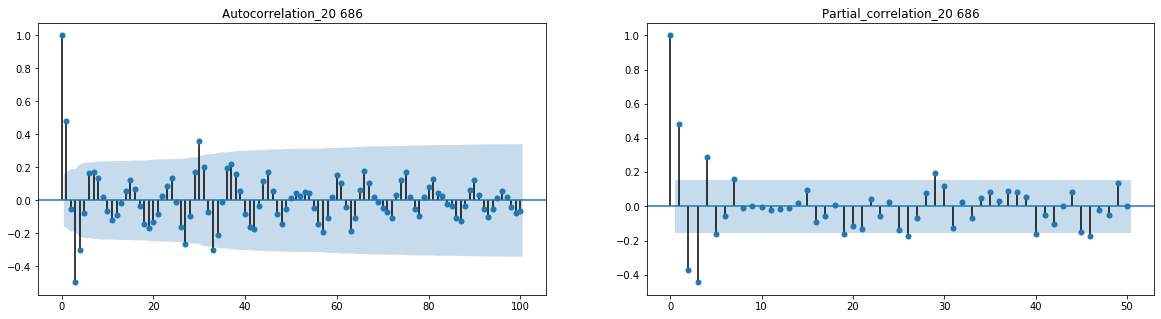

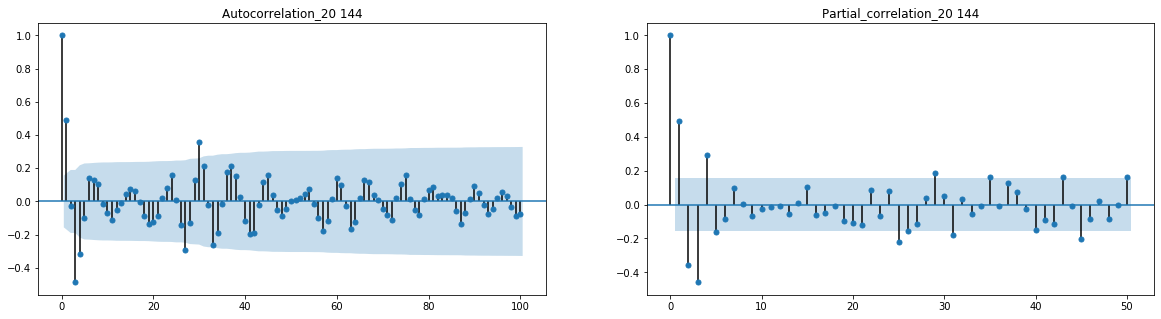

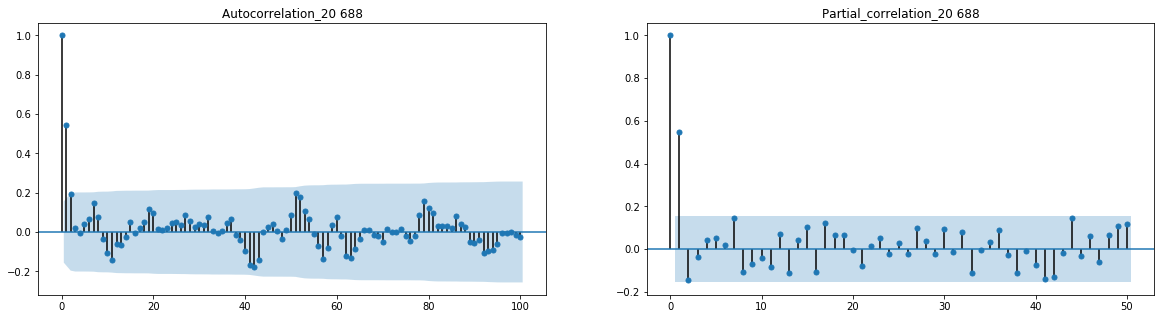

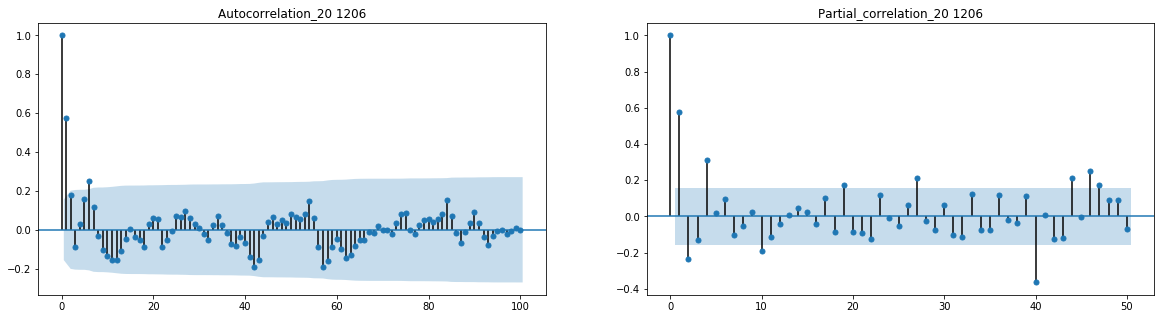

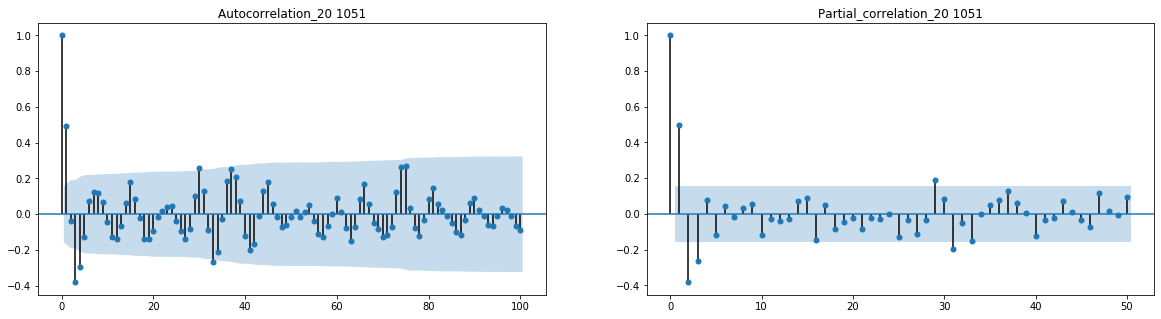

In [12]:
for s in set(df[df.scope == 1]['sku']):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))    
    
    plot_acf(df[df.sku == s]['POS_exposed w-1'], ax=ax[0], lags=100, title="Autocorrelation_20 " + str(s))
    plot_pacf(df[df.sku == s]['POS_exposed w-1'], ax=ax[1], lags=50, title="Partial_correlation_20 " + str(s))

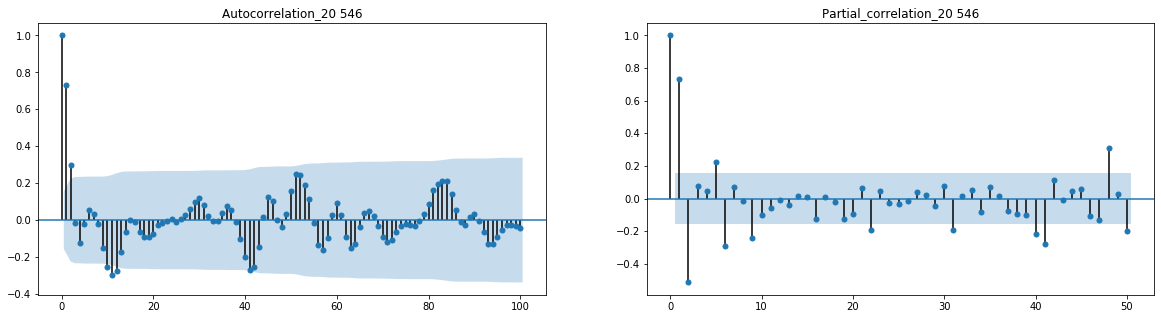

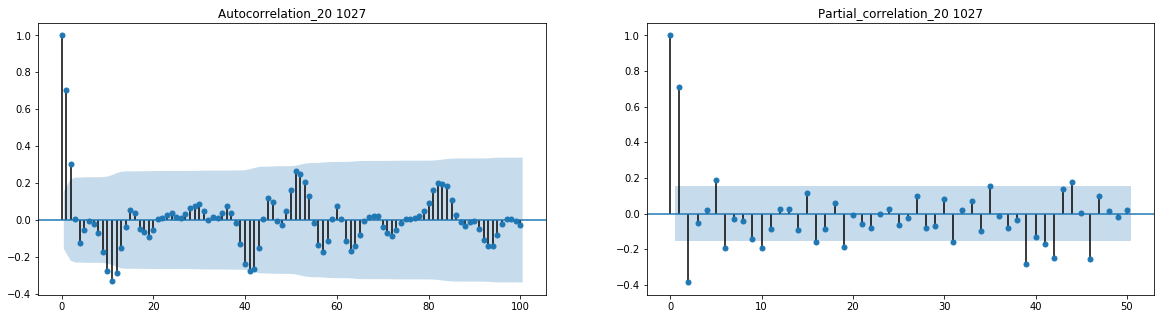

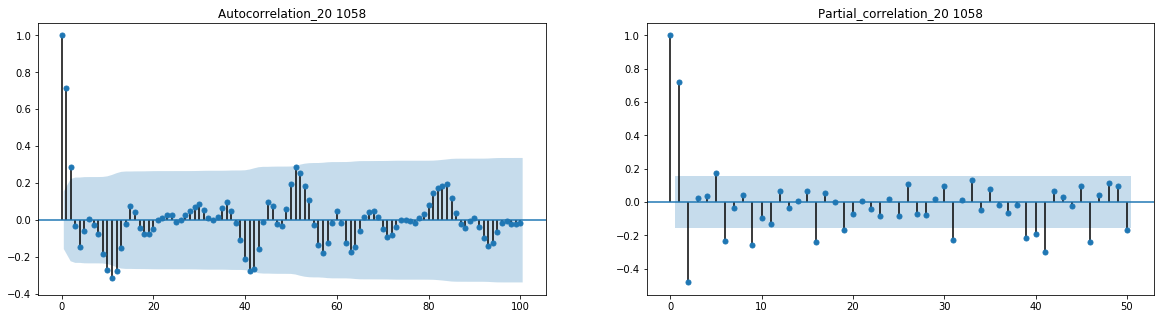

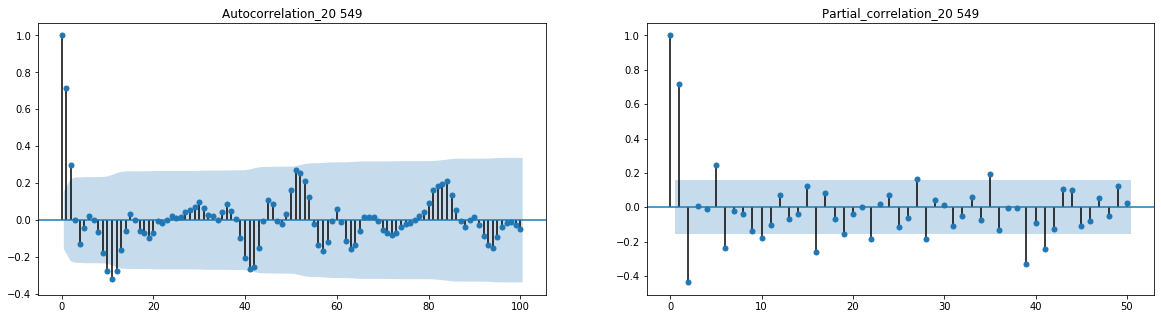

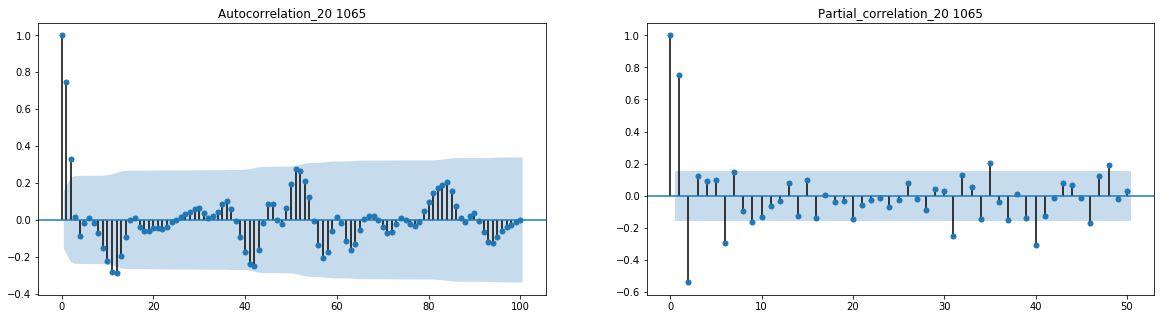

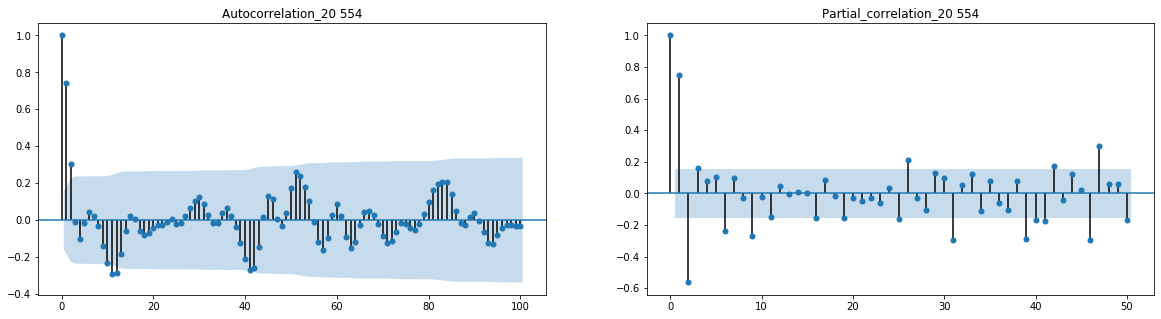

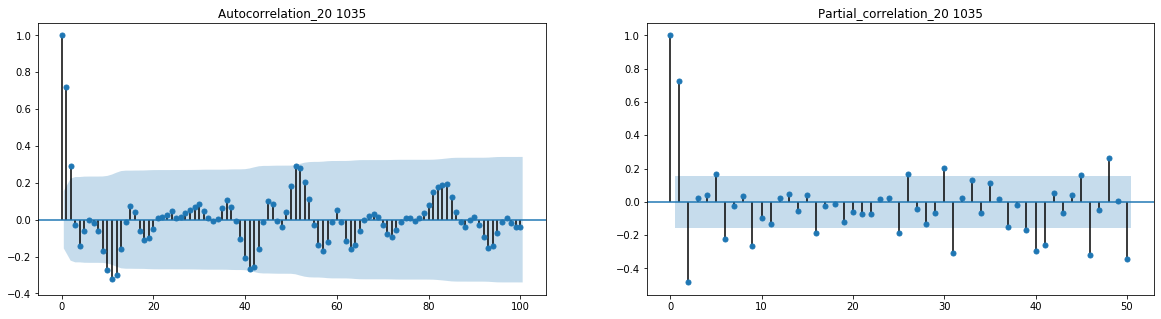

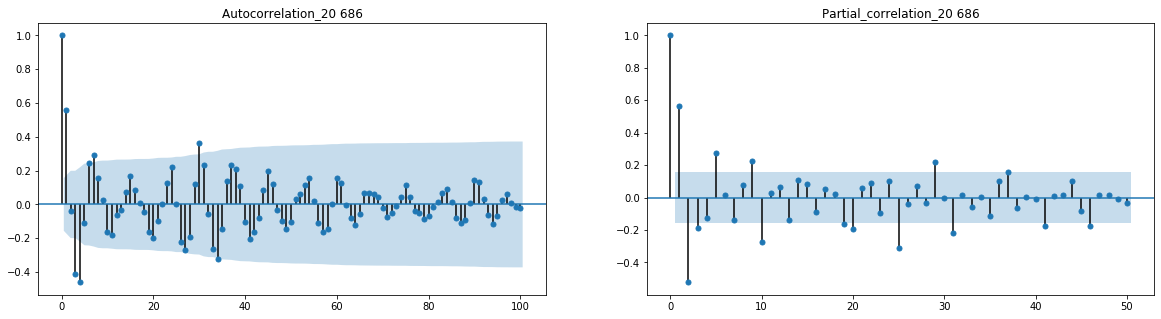

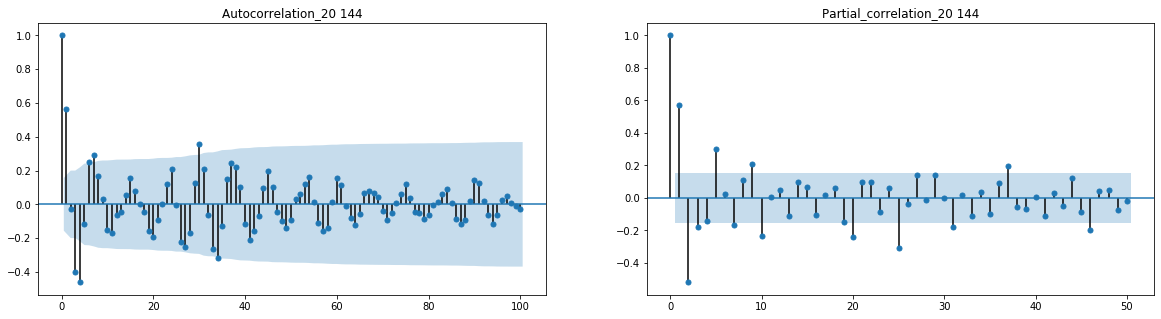

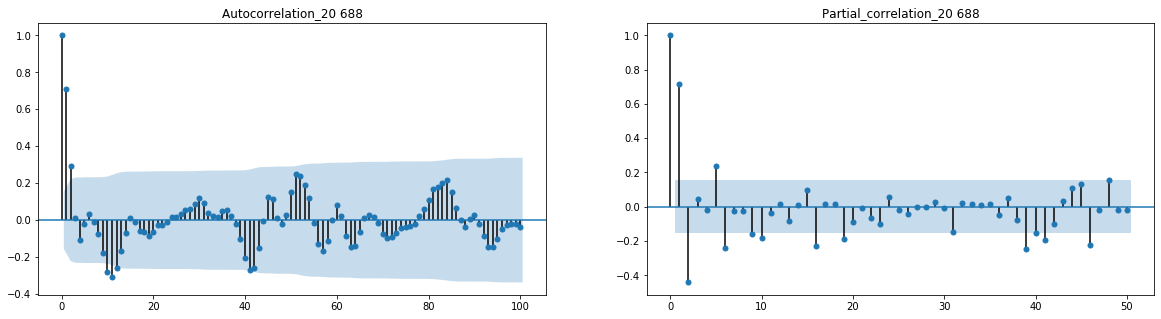

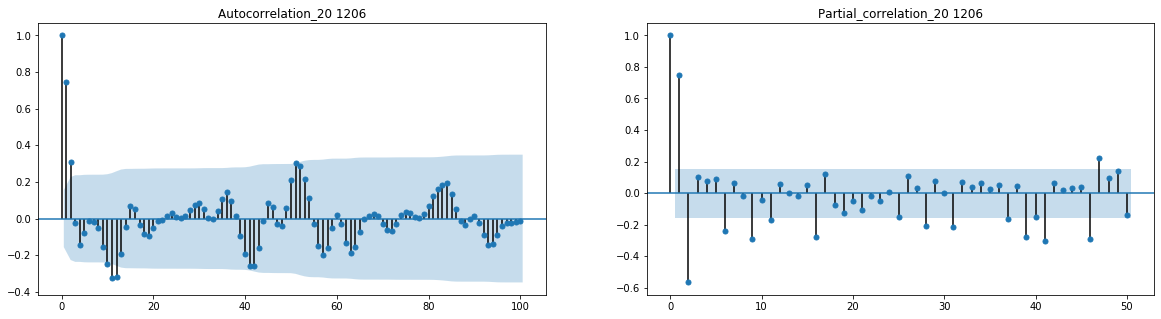

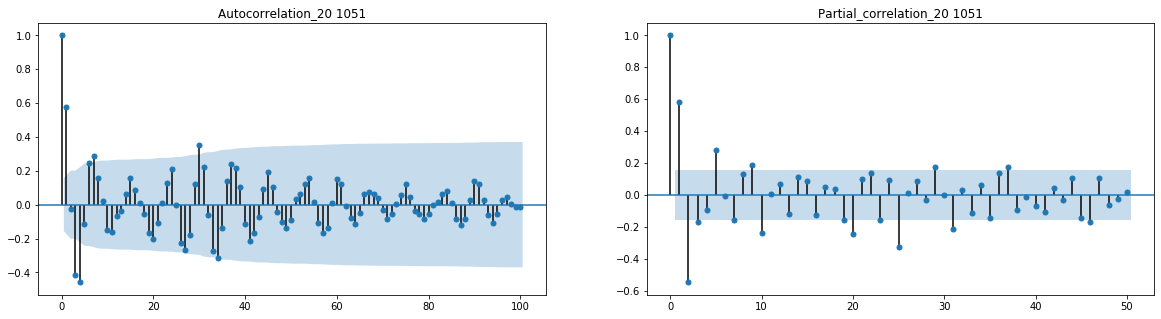

In [13]:
for s in set(df[df.scope == 1]['sku']):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))    
    
    plot_acf(df[df.sku == s]['price'], ax=ax[0], lags=100, title="Autocorrelation_20 " + str(s))
    plot_pacf(df[df.sku == s]['price'], ax=ax[1], lags=50, title="Partial_correlation_20 " + str(s))



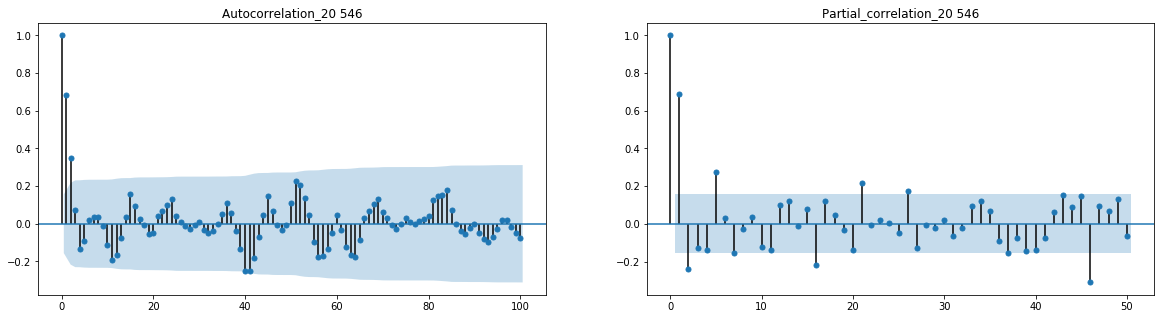

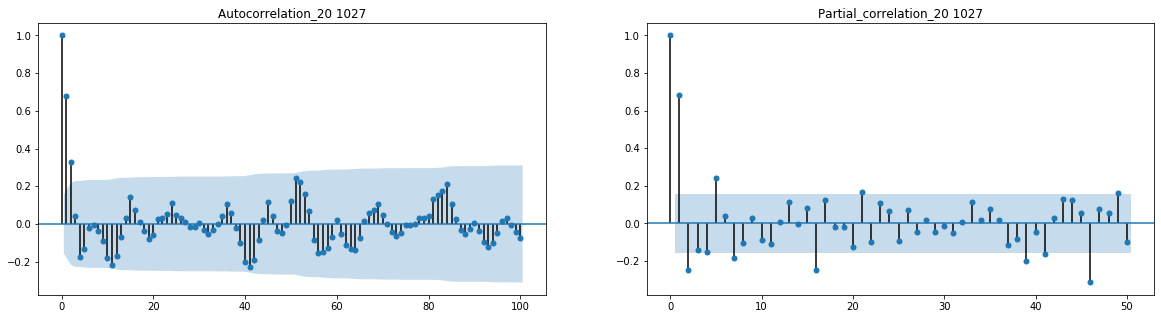

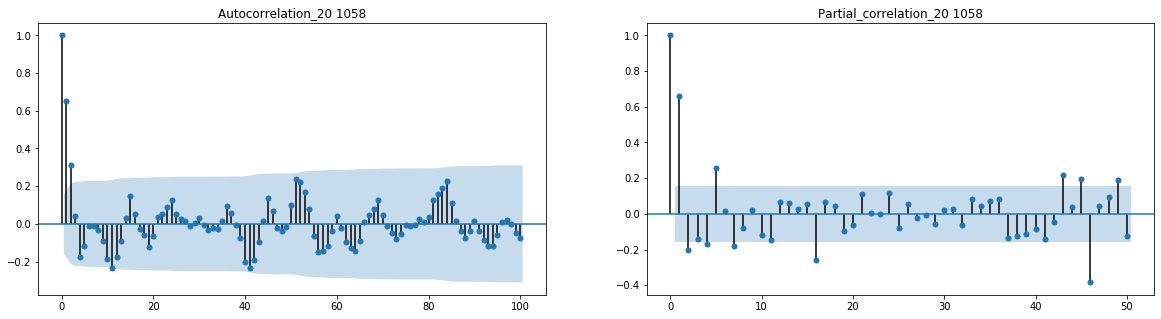

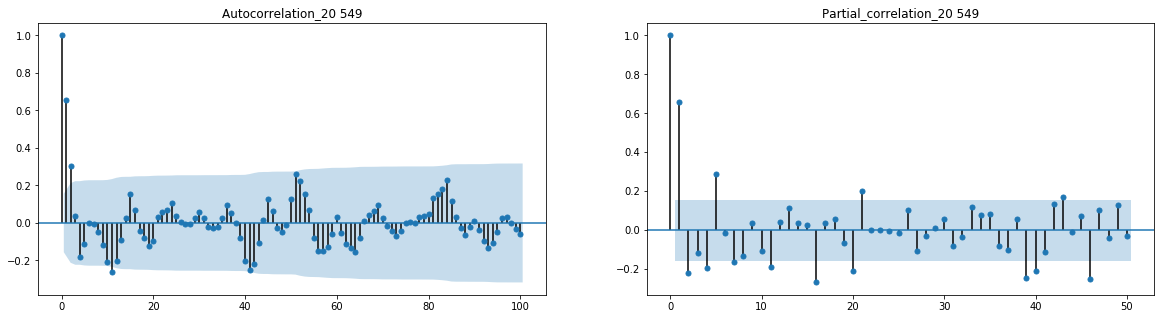

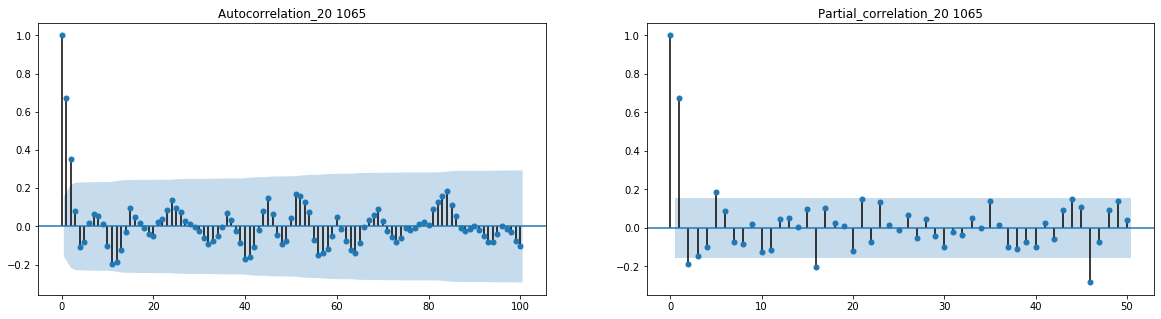

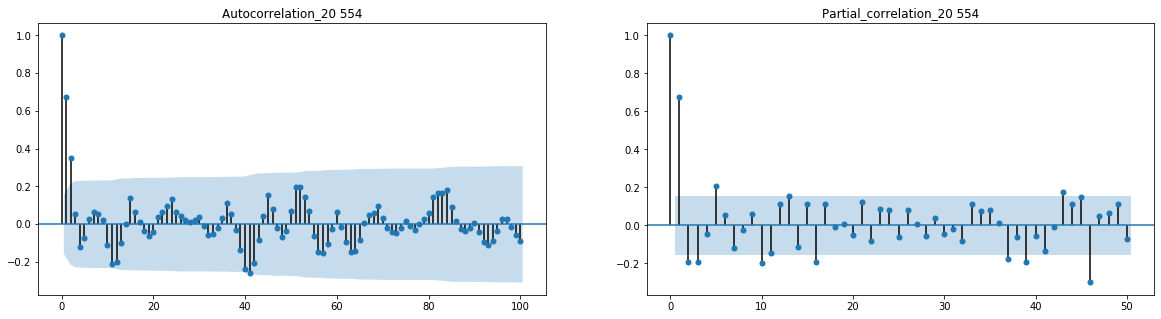

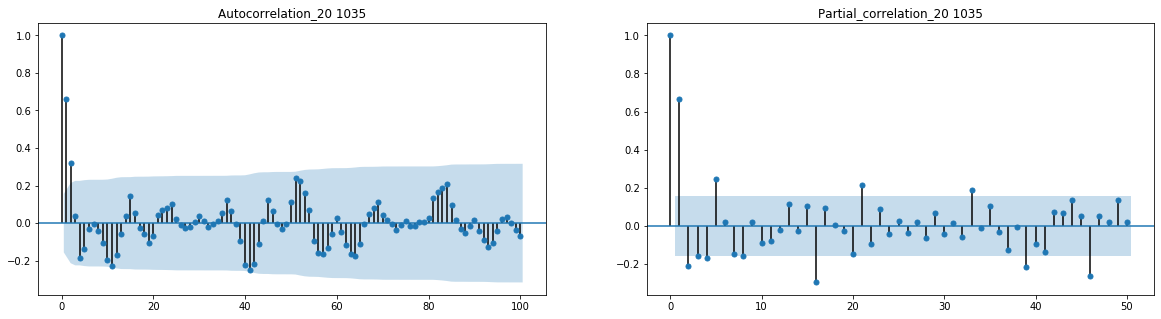

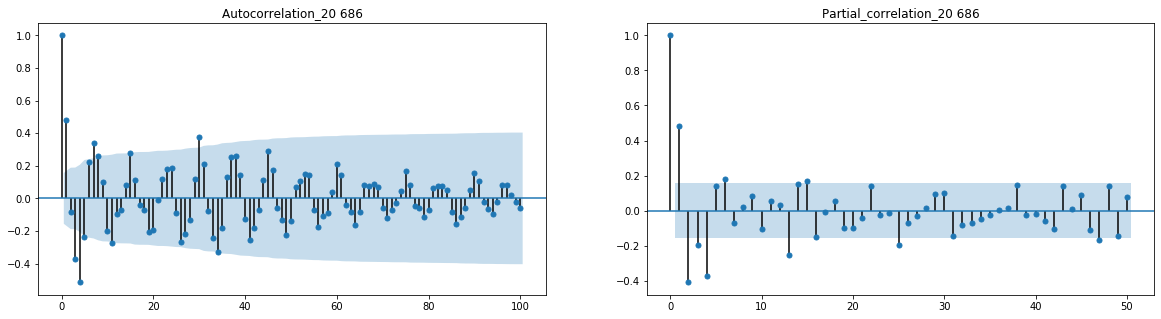

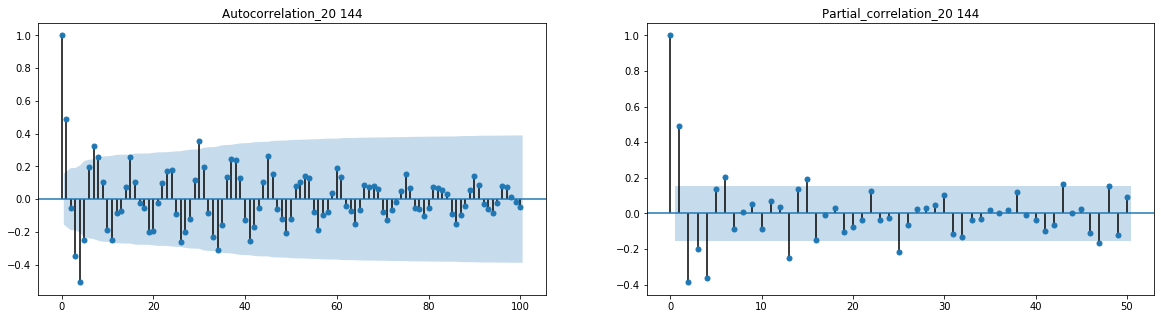

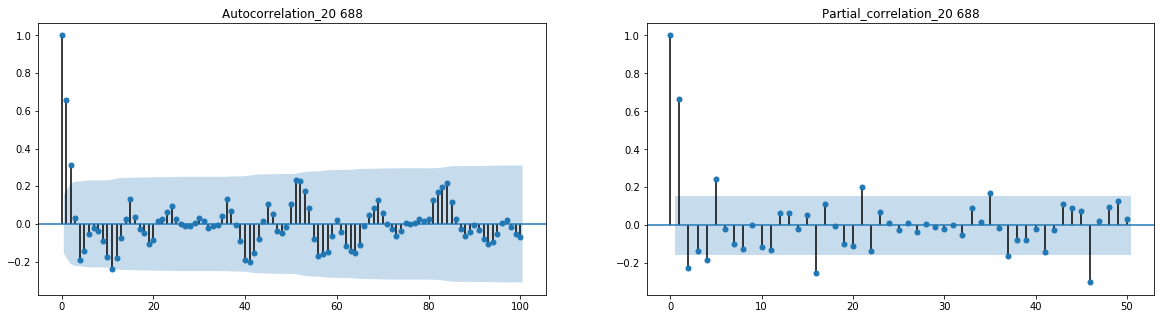

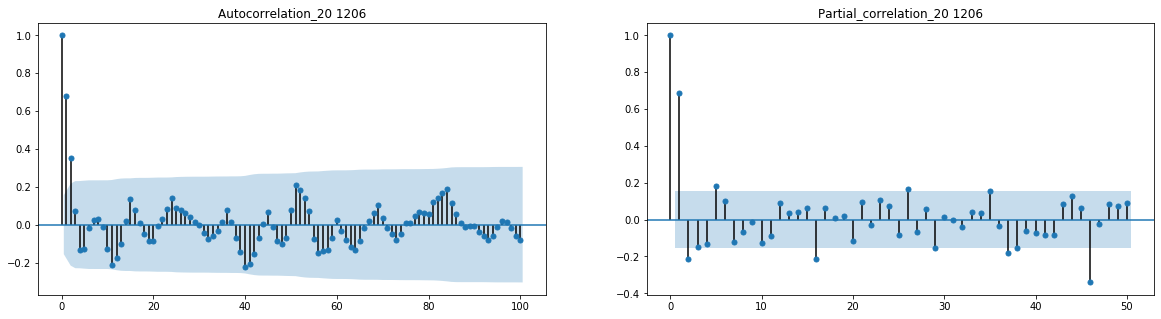

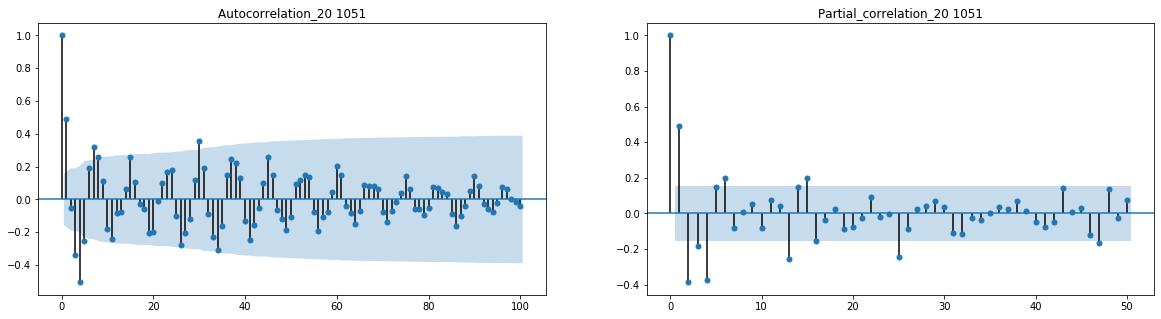

In [14]:
for s in set(df[df.scope == 1]['sku']):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))    
    
    plot_acf(df[df.sku == s]['volume_on_promo w-1'], ax=ax[0], lags=100, title="Autocorrelation_20 " + str(s))
    plot_pacf(df[df.sku == s]['volume_on_promo w-1'], ax=ax[1], lags=50, title="Partial_correlation_20 " + str(s))



## Decomposition of time series

In [15]:
df_decomp = df.copy()

C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


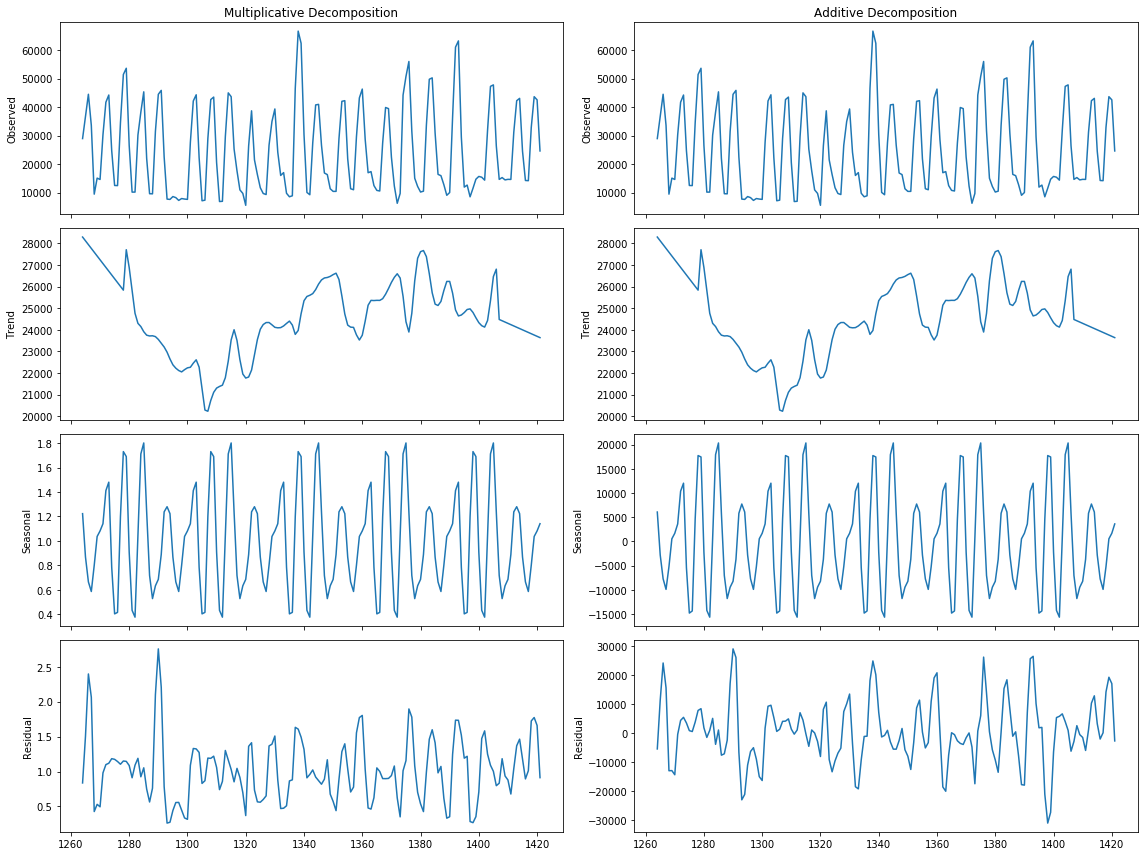

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# PLOT FOR SKU = 1051
df_decomp = df_decomp[df_decomp.sku == 1051]

decomposition_multiplicative = seasonal_decompose(df_decomp['sales w-1'], model='multiplicative', extrapolate_trend='freq', freq=30)
decomposition_additive = seasonal_decompose(df_decomp['sales w-1'], model='additive', extrapolate_trend='freq', freq=30)

# We define a function to be able to customize the single plots if we want.
# Alternatively, we can just call decomposition_multiplicative.plot()

def plotseasonal(decomposition, axes, title=""):
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_title(title)
    axes[0].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))
plotseasonal(decomposition_multiplicative, axes[:,0],"Multiplicative Decomposition")
plotseasonal(decomposition_additive, axes[:,1], "Additive Decomposition")
plt.tight_layout()
plt.show();

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 1895
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 6019 non-null   datetime64[ns]
 1   sku                  6019 non-null   int64         
 2   pack                 6019 non-null   int32         
 3   size (GM)            6019 non-null   float64       
 4   brand                6019 non-null   int32         
 5   price                6019 non-null   float64       
 6   POS_exposed w-1      6019 non-null   float64       
 7   volume_on_promo w-1  6019 non-null   float64       
 8   sales w-1            6019 non-null   float64       
 9   scope                6019 non-null   int64         
 10  target               5719 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int32(2), int64(2)
memory usage: 517.3 KB


In [33]:
def mean_rolling_window(df, attr_name : str, winsize=2, extended=True) -> pd.DataFrame :
    
    rolling_window = []
    
    if extended:
        for s in set(df.sku):
            window_single_sku = df[df.sku == s][attr_name].expanding(winsize).mean()
            rolling_window.extend(window_single_sku)
    
    else:
        for s in set(df.sku):
            window_single_sku = df[df.sku == s][attr_name].rolling(window=winsize).mean()
            rolling_window.extend(window_single_sku)

    df = df.sort_values(['sku'])
    df["mean_" + str(attr_name)] = rolling_window
    return df

df = mean_rolling_window(df, "sales w-1")
df

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target,mean_sales w-1
0,2016-12-10,144,0,114.23,1,2.18,73.0,100.000000,36209.0,1,51320.0,NaN
100,2018-11-10,144,0,114.23,1,3.50,0.0,3.341850,22895.0,1,15548.0,16225.000000
19,2017-04-22,144,0,114.23,1,2.00,23.0,99.143119,53438.0,1,64206.0,15604.333333
33,2017-07-29,144,0,114.23,1,3.88,0.0,3.821351,9764.0,1,9442.0,18322.250000
70,2018-04-14,144,0,114.23,1,3.49,0.0,5.081042,14149.0,1,13964.0,17242.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6000,2019-02-16,2718,1,395.41,0,1.10,0.0,0.000000,14752.0,0,30627.0,11879.147287
5966,2018-06-23,2718,1,395.41,0,1.09,2.0,32.625984,30480.0,0,29950.0,11910.361538
5901,2017-03-25,2718,1,395.41,0,1.10,0.0,67.984667,32218.0,0,31860.0,11897.236641
5972,2018-08-04,2718,1,395.41,0,1.10,2.0,13.988944,34370.0,0,34350.0,11910.545455


In [43]:
def max_rolling_window(df, attr_name: str, winsize=2, extended=True) -> pd.DataFrame:
    """
    For each row compute the mean of n previous rows (extended -> all previous rows)
    @param df:
    @param attr_name: name of the column to take into account
    @param winsize: with extended keep it always 2
    @param extended: non fixed window mode
    @return: df ordered by sku
    """
    df = df.sort_values(['sku', 'Date'])

    # Default branch
    if extended:
        extended_window = []

        for s in sorted(set(df.sku)):
            print(s)
            window_single_sku = df[df.sku == s][attr_name].expanding(winsize).max()
            extended_window.extend(window_single_sku)

        df["max_" + str(attr_name) + "_extended"] = extended_window

    else:
        rolling_window = []
        df = df.sort_values(['sku', 'Date'])

        for s in sorted(set(df.sku)):
            window_single_sku = df[df.sku == s][attr_name].rolling(window=winsize).max()
            rolling_window.extend(window_single_sku)

        df["max_" + str(attr_name) + "_rolled"] = rolling_window

    return df


df = max_rolling_window(df, "price")
display(df)

TypeError: data must be a dict, got:            Date   sku  pack  size (GM)  brand  price  POS_exposed w-1  \
0    2016-12-10   144     0     114.23      1   2.18             73.0   
1    2016-12-17   144     0     114.23      1   2.00             45.0   
2    2016-12-24   144     0     114.23      1   2.05             17.0   
3    2016-12-31   144     0     114.23      1   3.00              2.0   
4    2017-01-07   144     0     114.23      1   2.99              2.0   
...         ...   ...   ...        ...    ...    ...              ...   
6014 2019-05-25  2718     1     395.41      0   1.11              0.0   
6015 2019-06-01  2718     1     395.41      0   1.30              1.0   
6016 2019-06-08  2718     1     395.41      0   1.55              0.0   
6017 2019-06-15  2718     1     395.41      0   1.55              0.0   
6018 2019-06-22  2718     1     395.41      0   1.12              0.0   

      volume_on_promo w-1  sales w-1  scope   target  mean_sales w-1  \
0              100.000000    36209.0      1  51320.0             NaN   
1              100.000000    51320.0      1  66431.0    16292.971154   
2              100.000000    66431.0      1  57001.0    94214.523810   
3              100.000000    57001.0      1  15052.0    16693.181818   
4               28.534193    15052.0      1  22016.0    16306.410256   
...                   ...        ...    ...      ...             ...   
6014            26.050480    33875.0      0  33328.0    11587.600000   
6015            43.099496    33328.0      0  22512.0    10489.750000   
6016             0.000000    22512.0      0  17461.0    11194.296296   
6017             0.000000    17461.0      0  17105.0    11372.189189   
6018             0.080094    17105.0      0  35144.0    11058.031250   

      mean_price  max_price  
0            NaN        NaN  
1           1.12       1.16  
2           1.50       1.16  
3           1.50       1.16  
4           1.50       1.16  
...          ...        ...  
6014        1.95       1.95  
6015        1.95       1.95  
6016        1.95       1.95  
6017        1.95       1.95  
6018        1.95       1.95  

[6019 rows x 14 columns]

In [31]:
len(df[df["mean_sales w-1"].isnull()])

43

In [ ]:
df = df.sort_values(['Date', 'sku'])
df

In [118]:
df = pd.DataFrame({'col': [0,1,2,3,4,5,np.nan]})
df

,col
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0
5,5.0
6,NaN


In [121]:
df.rolling(window=3).max()

,col
0,NaN
1,NaN
2,2.0
3,3.0
4,4.0
5,5.0
6,NaN
